## Imports and load data. 

In [37]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import scipy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
#UPLOAD_DATA
!rm *.csv

from google.colab import files
#LOAD TRAIN_DATA
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
td = pd.read_csv(filename)

Please load the raw csv data


Saving preprocessed_train_2.csv to preprocessed_train_2.csv


In [38]:
#LOAD TEST_DATA
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
test_d = pd.read_csv(filename)

Please load the raw csv data


Saving preprocessed_test_2.csv to preprocessed_test_2.csv


In [39]:
#Drop numeration column
drop_list = ['patient_id']
td.drop(drop_list, axis= 1, inplace = True)
test_d.drop(drop_list, axis= 1, inplace = True)

## VirusScore dependency on blood type:
### We can infer that blood type A separates the VisurScore distribution:

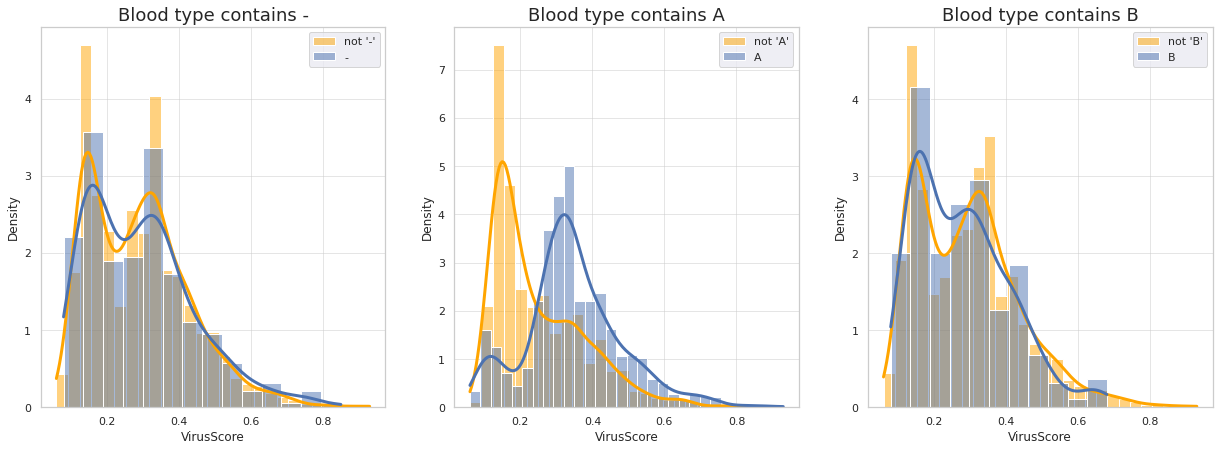

In [40]:
target = 'VirusScore'

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
sns.set(style="darkgrid")
for i, cur_type in enumerate(['-', 'A', 'B']):
 filter_mask = td['blood_type'].str.contains(cur_type)
 sns.histplot(data=td[target][~filter_mask], ax=ax[i], stat="density", kde=True,
 line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type))
 sns.histplot(data=td[target][filter_mask], ax=ax[i], stat="density", kde=True,
 line_kws={"linewidth": 3}, label=cur_type)
 ax[i].set_title("Blood type contains " + cur_type, fontsize=18)
 ax[i].legend(), ax[i].grid(alpha=0.5)

## Extract new feature based on blood type A.

In [41]:
def bool_to_int(val):
  return 1 if val == 'True' else 0
  
def process_blood(data):
  data['cont_A'] = data['blood_type'].str.contains('A')
  data['cont_A'] = data['cont_A'].astype(str).apply(lambda x : bool_to_int(x))
  drop_list = ['blood_type']
  data.drop(drop_list, axis= 1, inplace = True)
  return data

td = process_blood(td)
test_d = process_blood(test_d)


## Split data

In [42]:
random = 14
from sklearn.model_selection import train_test_split
train_sub, val_sub = train_test_split(td, test_size = 0.2, random_state = random)

#DEFINITION OF DATASETS
x_cols = list(set(td.columns) - set([target]))
X_train_sub = train_sub[x_cols]
y_train_sub = train_sub[target]

X_val_sub = val_sub[x_cols]
y_val_sub = val_sub[target]

X_train = td[x_cols]
y_train = td[target]

X_test = test_d[x_cols]
y_test = test_d[target]

## Linear Regressor implementation with MSE loss

In [43]:
#LINEAR_REGRESSOR
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        m = y.size
        vec_loss = (X.dot(w) + b) - y
        loss = np.square(np.linalg.norm(vec_loss))/m

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        m = y.size
        vec_loss = ((X.dot(w) + b) - y)
        g_w = ((np.transpose(X)).dot(vec_loss)*2)/m
        g_b = (np.sum(vec_loss)*2)/m

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            g_w, g_b = LinearRegressor.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        y_pred = np.tranpose(X).dot(self.w) + self.b

        return y_pred

## Implement subgradients for Linear Regressor

In [44]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


## Compare gradients:

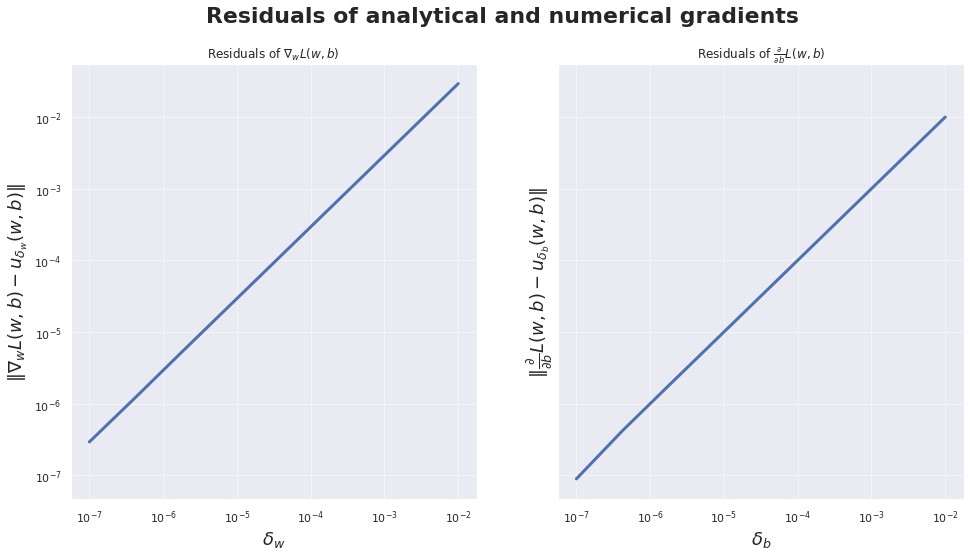

In [45]:
compare_gradients(X_train_sub.to_numpy(), y_train_sub.to_numpy(), deltas=np.logspace(-7, -2, 9))

## Testing Learning Rate convergence and properties for LinearRegressor

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')


lr size = 1e-09, Best train loss = 0.10419939934538945, Best validation loss = 0.10559180289255872
lr size = 1e-08, Best train loss = 0.10418368254181082, Best validation loss = 0.10557615549395748
lr size = 1e-07, Best train loss = 0.1040266716035094, Best validation loss = 0.10541983667211155
lr size = 1e-06, Best train loss = 0.10247216637753945, Best validation loss = 0.10387206101142583
lr size = 1e-05, Best train loss = 0.08838708727056639, Best validation loss = 0.08983675450897749
lr size = 0.0001, Best train loss = 0.029042484935602277, Best validation loss = 0.030222646846101892
lr size = 0.001, Best train loss = 0.013453172850041968, Best validation loss = 0.013801691639466571
lr size = 0.01, Best train loss = 0.008085472039001205, Best validation loss = 0.00798561122262149
lr size = 0.1, Best train loss = 0.00756511250703609, Best validation loss = 0.007256930563699115


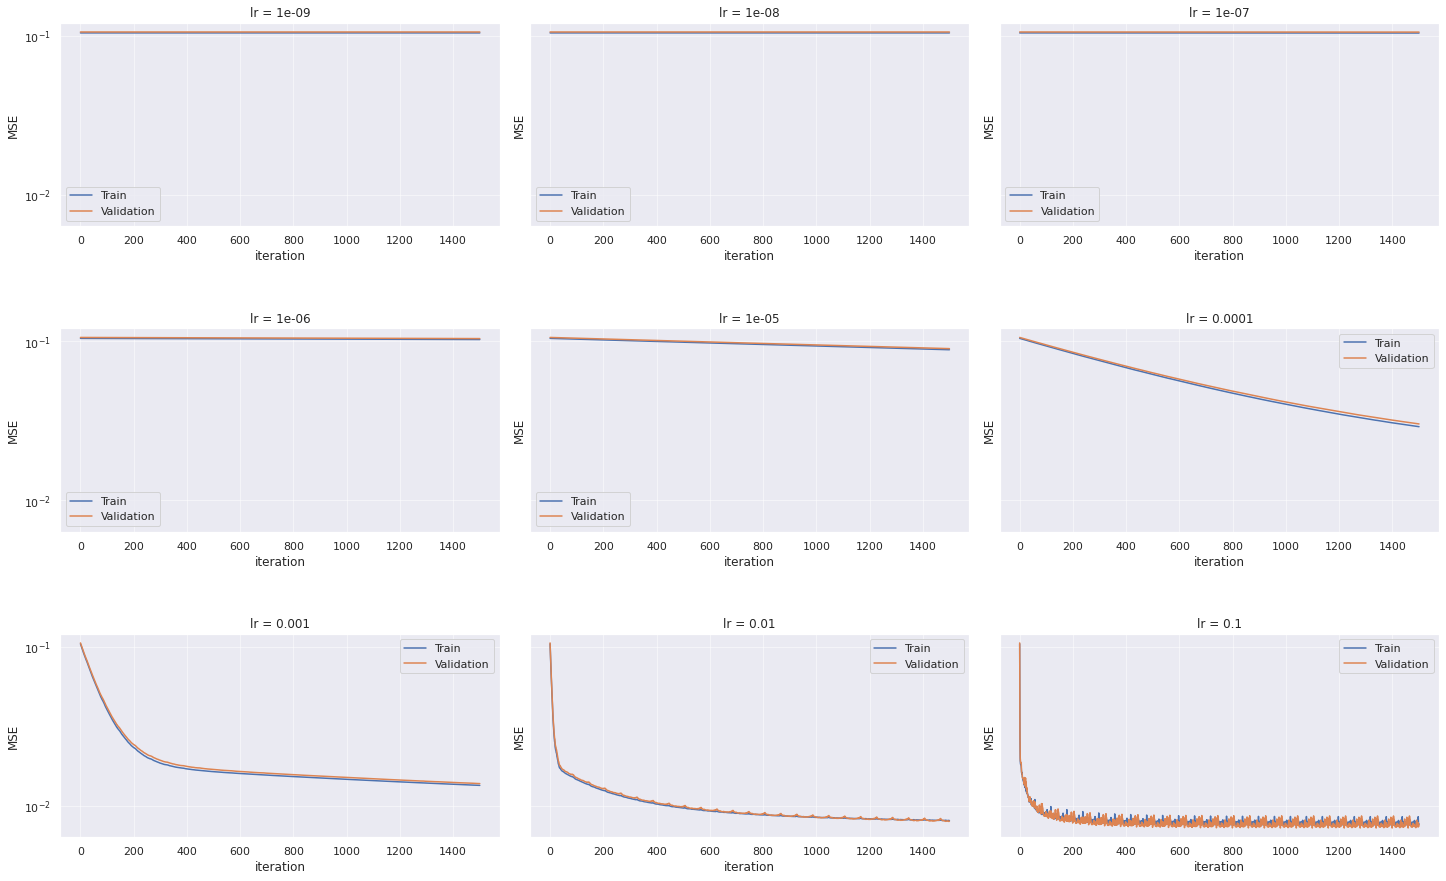

In [47]:
test_lr(X_train_sub, y_train_sub, X_val_sub, y_val_sub)

## Dummy Regressor evaluation as a baseline.

In [48]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

scores = cross_validate(DummyRegressor(), X_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
dummy_train_score = abs(np.mean(scores['train_score']))
dummy_valid_score = abs(np.mean(scores['test_score']))
print(dummy_train_score)
print(dummy_valid_score)

#For later use
dummy_regr = DummyRegressor()
dummy_regr = dummy_regr.fit(X_train, y_train)

0.019708137684461807
0.019715523166232637


In [49]:
from operator import itemgetter

def arg_min(items):
  return min(enumerate(items), key=itemgetter(1))

## Ridge regularization

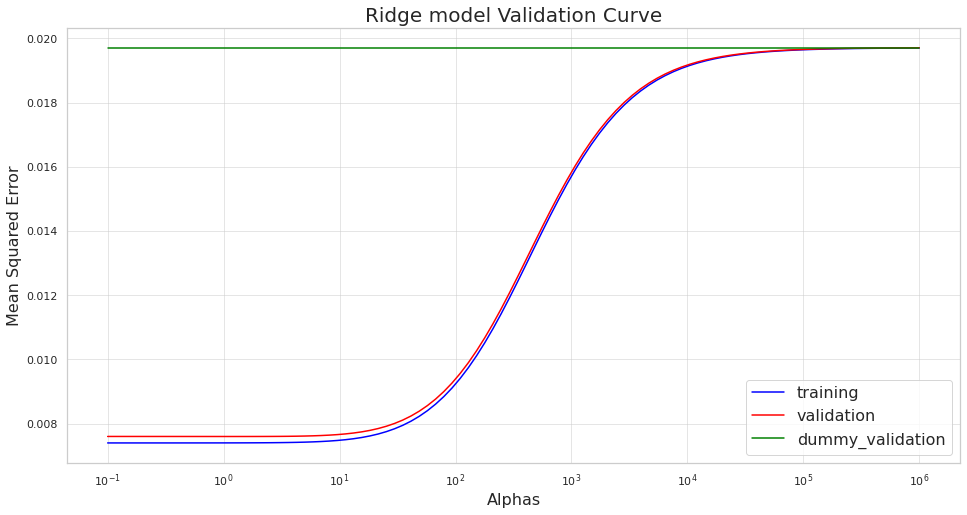

min valid 0.007599054343735911
min train 0.007398601398079667


In [50]:
sns.set(style="whitegrid")
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

alphas = np.logspace(-1, 6, 100)
train_scores = []
valid_scores = []
dummy_valid_scores = np.ones(alphas.size)*dummy_valid_score

for alpha in alphas:
  scores = cross_validate(Ridge(alpha=alpha, fit_intercept=True), X_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(abs(np.mean(scores['train_score'])))
  valid_scores.append(abs(np.mean(scores['test_score'])))

_, ax = plt.subplots(figsize=(16, 8))

ax.semilogx(alphas, train_scores, color='blue', label='training')
ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.semilogx(alphas, dummy_valid_scores, color='green', label='dummy_validation')
ax.set_title('Ridge model Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid " + str(min(valid_scores)))
print("min train " + str(min(train_scores)))

## Zoom in to find optimal alpha parameter:

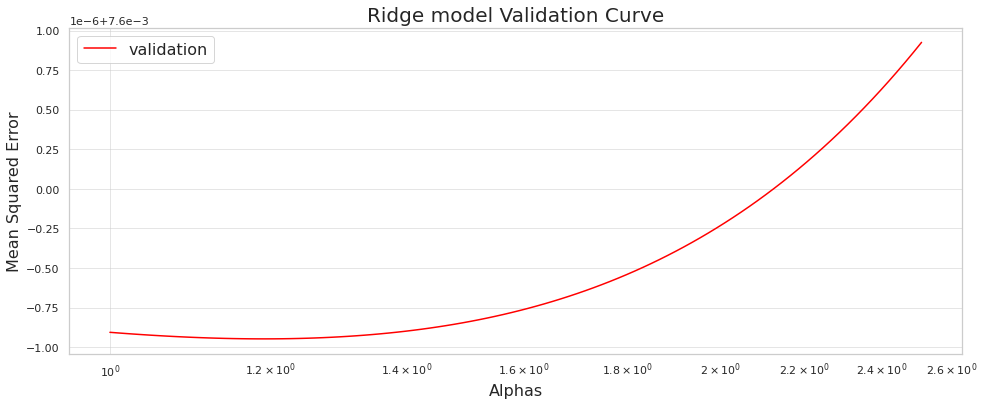

min valid score 0.007599052442721477, optimal alpha= 1.1933495584863842
min valid 0.007399727259952289


In [51]:
#ZOOOOM:
alphas = np.logspace(0, 0.4, 100)
valid_scores = []
train_scores = []

for alpha in alphas:
  scores = cross_validate(Ridge(alpha=alpha, fit_intercept=True), X_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  valid_scores.append(abs(np.mean(scores['test_score'])))
  train_scores.append(abs(np.mean(scores['train_score'])))

_, ax = plt.subplots(figsize=(16, 6))

ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.set_title('Ridge model Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid score " + str(min(valid_scores)) + ", optimal alpha= " + str(alphas[arg_min(valid_scores)[0]]))
print("min valid " + str(min(train_scores)))

## Optimal RidgeRegerssor:

In [52]:
alpha_ridge_opt = 1.1933495584863842

ridge_opt = Ridge(alpha=alpha_ridge_opt, fit_intercept=True)
ridge_opt = ridge_opt.fit(X_train, y_train)

ridge_coef = [abs(x) for x in ridge_opt.coef_]

#5 most important features for predicting virusScore
[feature for _, feature in sorted(zip(ridge_coef, x_cols), reverse=True)][:5]

['shortness_of_breath', 'num_of_siblings', 'PCR_08', 'fever', 'cont_A']

## Columns correlation distribution of Optimal Ridge Regressor.

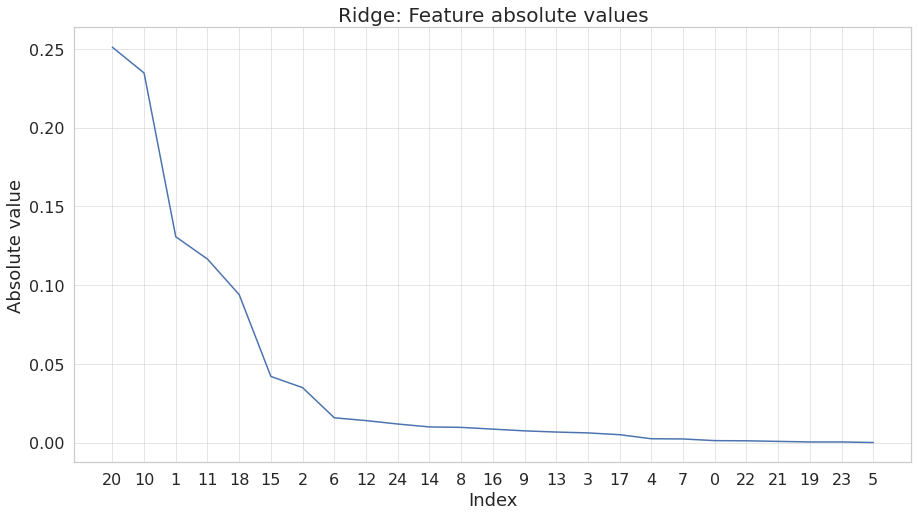

In [53]:
ridge_i = [i for _, i in sorted(zip(ridge_coef, range(len(x_cols))), reverse=True)]
ridge_coef_sort = sorted(ridge_coef, reverse=True)

plt.figure(figsize=(15, 8))
plt.plot(ridge_coef_sort)
plt.title('Ridge: Feature absolute values', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Absolute value', fontsize=18)
plt.xticks(ticks=range(len(ridge_i)), labels=ridge_i, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.5)

## Lasso Regularization

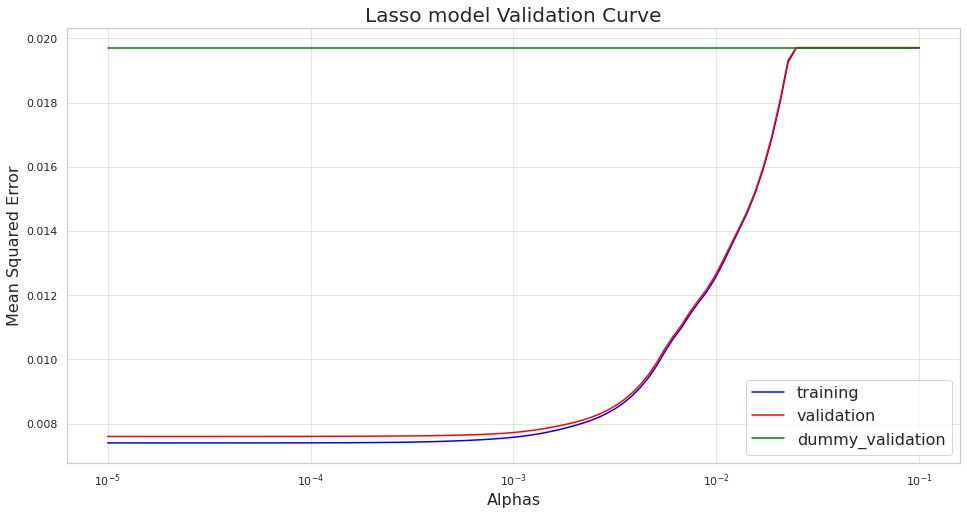

min valid 0.007600481046648041
min train 0.007398619023641262


In [54]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

alphas = np.logspace(-5, -1, 100)
train_scores = []
valid_scores = []
dummy_valid_scores = np.ones(alphas.size)*dummy_valid_score

for alpha in alphas:
  scores = cross_validate(Lasso(alpha=alpha, fit_intercept=True), X_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(abs(np.mean(scores['train_score'])))
  valid_scores.append(abs(np.mean(scores['test_score'])))

_, ax = plt.subplots(figsize=(16, 8))

ax.semilogx(alphas, train_scores, color='blue', label='training')
ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.semilogx(alphas, dummy_valid_scores, color='green', label='dummy_validation')
ax.set_title('Lasso model Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid " + str(min(valid_scores)))
print("min train " + str(min(train_scores)))

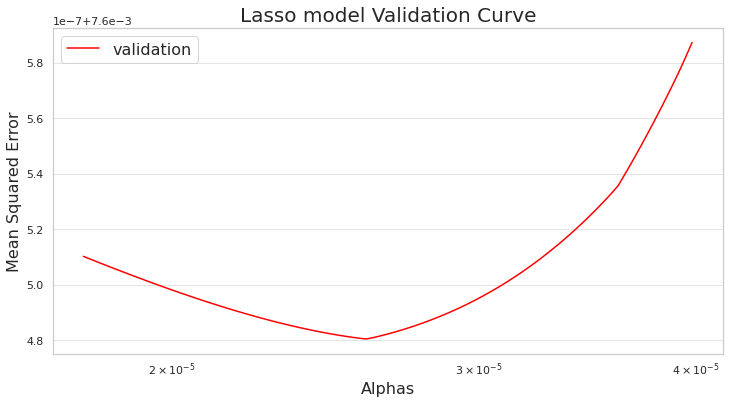

min valid score 0.00760048039071502, optimal alpha= 2.5859865552953022e-05
min train 0.0073986827975674576


In [55]:
#ZOOOOOOOOM:
alphas = np.logspace(-4.75, -4.4, 100)
valid_scores = []
train_scores = []
dummy_valid_scores = np.ones(alphas.size)*dummy_valid_score

for alpha in alphas:
  scores = cross_validate(Lasso(alpha=alpha, fit_intercept=True), X_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  valid_scores.append(abs(np.mean(scores['test_score'])))
  train_scores.append(abs(np.mean(scores['train_score'])))

_, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.set_title('Lasso model Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid score " + str(min(valid_scores)) + ", optimal alpha= " + str(alphas[arg_min(valid_scores)[0]]))
print("min train " + str(min(train_scores)))

## Optimal Lasso Regressor.

In [56]:
alpha_lasso_opt = 2.5859865552953022e-05

lasso_opt = Lasso(alpha=alpha_lasso_opt, fit_intercept=True)
lasso_opt = lasso_opt.fit(X_train, y_train)

lasso_coef = [abs(x) for x in lasso_opt.coef_]

#5 most important features for predicting virusScore
[feature for _, feature in sorted(zip(lasso_coef, x_cols), reverse=True)][:5]

['shortness_of_breath', 'num_of_siblings', 'PCR_08', 'fever', 'cont_A']

## Columns correlation distribution of Optimal Lasso Regressor.

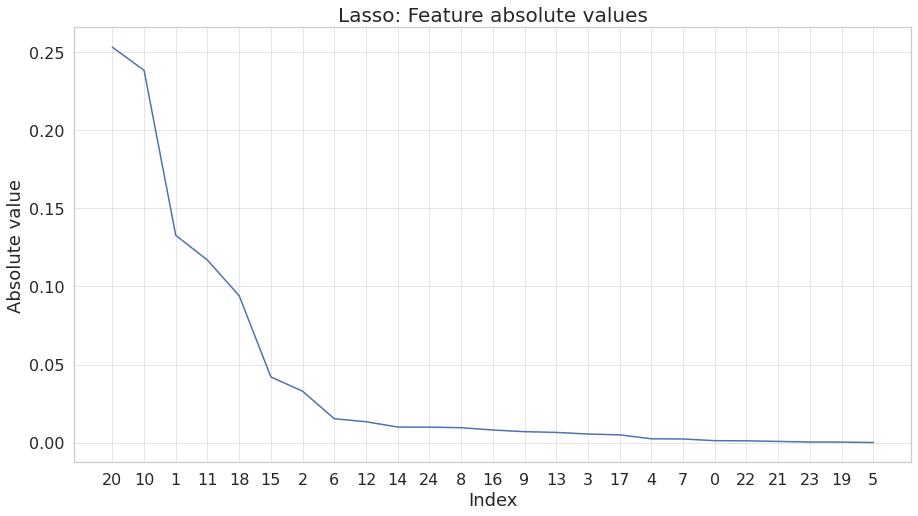

In [57]:
lasso_i = [i for _, i in sorted(zip(lasso_coef, range(len(x_cols))), reverse=True)]
lasso_coef_sort = sorted(lasso_coef, reverse=True)

plt.figure(figsize=(15, 8))
plt.plot(lasso_coef_sort)
plt.title('Lasso: Feature absolute values', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Absolute value', fontsize=18)
plt.xticks(ticks=range(len(lasso_i)), labels=lasso_i, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.5)

## Polynomial Linear Regressor.

In [58]:
from sklearn.preprocessing import PolynomialFeatures
td_copy = cp.deepcopy(td)
test_d_copy = cp.deepcopy(test_d)

pol_degree = 2
poly = PolynomialFeatures(degree = pol_degree, include_bias=False)
poly = poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)


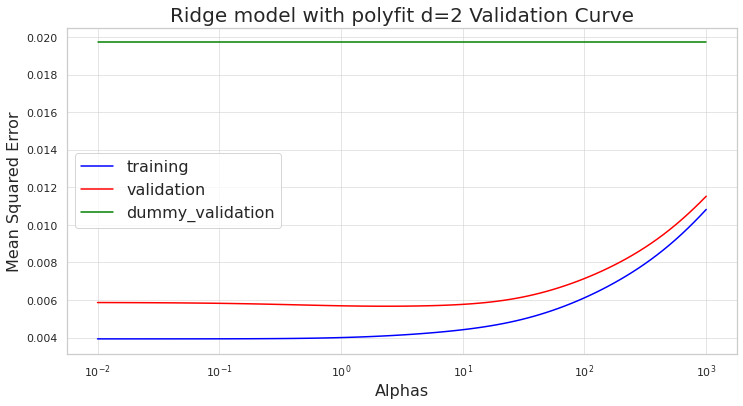

min valid 0.005669949207104315
min train 0.003931632378606145


In [70]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

alphas = np.logspace(-2, 3, 100)
train_scores = []
valid_scores = []
dummy_valid_scores = np.ones(alphas.size)*dummy_valid_score

for alpha in alphas:
  scores = cross_validate(Ridge(alpha=alpha, fit_intercept=True), X_train_poly, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(abs(np.mean(scores['train_score'])))
  valid_scores.append(abs(np.mean(scores['test_score'])))

_, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(alphas, train_scores, color='blue', label='training')
ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.semilogx(alphas, dummy_valid_scores, color='green', label='dummy_validation')
ax.set_title('Ridge model with polyfit d=2 Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid " + str(min(valid_scores)))
print("min train " + str(min(train_scores)))

## Zoom in for optimal alpha parameter.

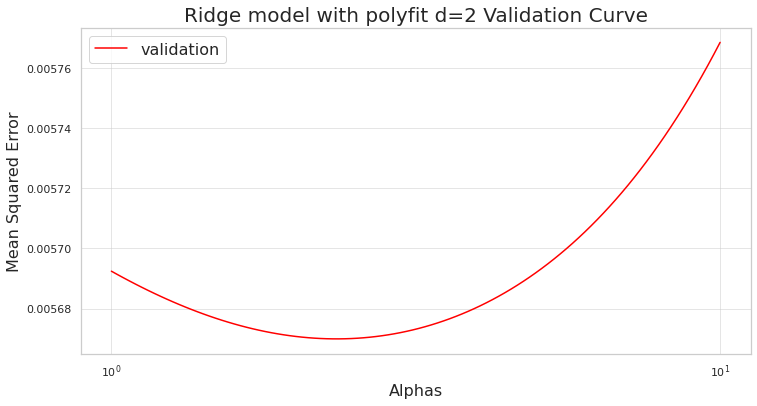

min valid score 0.005669949207104315, optimal alpha= 2.3644894126454075
min train 0.004000552981110535


In [72]:
#ZOOOOOOMM:
alphas = np.logspace(0, 1, 100)
valid_scores = []
train_scores = []
dummy_valid_scores = np.ones(alphas.size)*dummy_valid_score

for alpha in alphas:
  scores = cross_validate(Ridge(alpha=alpha, fit_intercept=True), X_train_poly, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  valid_scores.append(abs(np.mean(scores['test_score'])))
  train_scores.append(abs(np.mean(scores['train_score'])))

_, ax = plt.subplots(figsize=(12, 6))

ax.semilogx(alphas, valid_scores, color='red', label='validation')
ax.set_title('Ridge model with polyfit d=2 Validation Curve', fontsize=20)
ax.set_xlabel('Alphas', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=16)
_ = ax.legend(prop={"size":16})

plt.grid(alpha=0.5)
plt.show()
print("min valid score " + str(min(valid_scores)) + ", optimal alpha= " + str(alphas[arg_min(valid_scores)[0]]))
print("min train " + str(min(train_scores)))

## Optimal Polynomial Regressor

In [61]:
alpha_poly_opt = 2.3589963707015937
poly_ridge_opt = Ridge(alpha=alpha_poly_opt,fit_intercept=True)
poly_ridge_opt = poly_ridge_opt.fit(X_train_poly, y_train)

## Comparing different optimal regressors. 

In [62]:
#Test evaluation
from sklearn.metrics import mean_squared_error as mse
dummy_test_score = mse(dummy_regr.predict(X_test), y_test)
ridge_test_score = mse(ridge_opt.predict(X_test), y_test)
lasso_test_score = mse(lasso_opt.predict(X_test), y_test)
poly_test_score = mse(poly_ridge_opt.predict(X_test_poly), y_test)

print("dummy: " + str(dummy_test_score) +"\nridge: " + str(ridge_test_score) +
      "\nlasso: " + str(lasso_test_score) + "\npoly_ridge: " + str(poly_test_score))

dummy: 0.022621558350694446
ridge: 0.008479424938955565
lasso: 0.008480695236308207
poly_ridge: 0.006252498276582311


Polynomial Ridge Regression had the lowest loss of validation data during CV, while providing worse results than those of a linear Regressor. The possible explanation is that there has been an overfitting of Polynomial Regressor, despite using L2 regularization and evaluating with CV.